In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import joblib
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

pd.set_option('display.max_columns', None)

spark = SparkSession \
        .builder \
        .config("...") \
        .master("local")\
        .appName("egdgroup big data queries") \
        .getOrCreate()

sc = spark.sparkContext

In [8]:
credit_data = spark.read.option("header","true").option("inferSchema","true") \
.csv("creditcard.csv")

credit_data.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [9]:
credit_data.count()

284807

In [12]:
credit_data = credit_data.toPandas()

In [14]:
# check for null values
print(credit_data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


<Axes: >

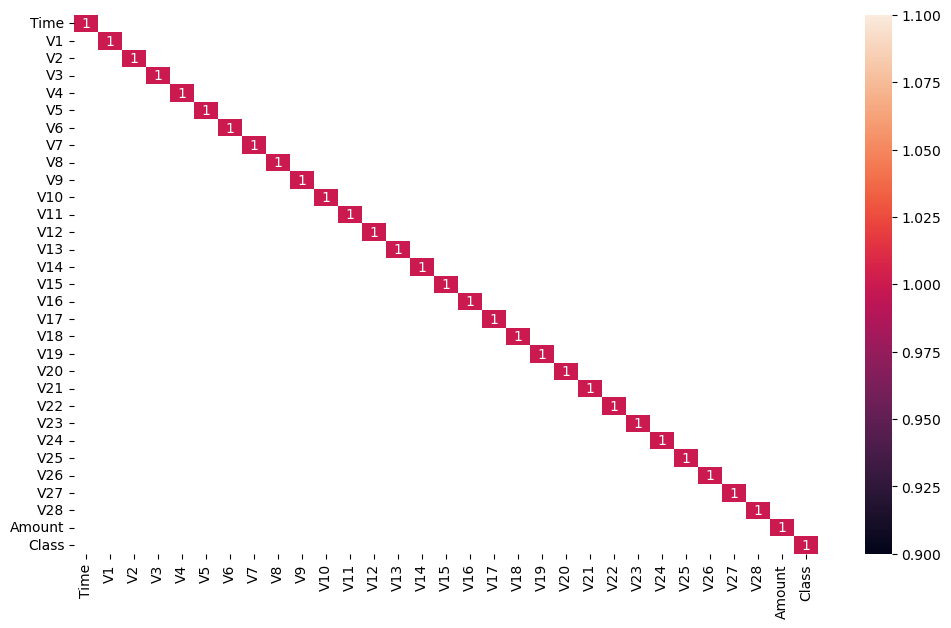

In [17]:
# calculate correlation matrix
corr = credit_data.corr()

# set the threshold
threshold = 0.4

# keep only the correlations above the threshold
corr = corr[corr > threshold]

# Create the figure and the axes objects
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corr,annot = True)

# Data Pre-processing

In [19]:
# select only quantitative variables
numerical_vars = credit_data.iloc[:,1:-1].select_dtypes(include=['float64', 'int64']).columns

# standardize the numerical variables
scaler = StandardScaler()
credit_data[numerical_vars] = scaler.fit_transform(credit_data[numerical_vars])

# Data Mining

In [20]:
# fix random seed for reproducibility
np.random.seed(7)

In [22]:
# Separating the target label from the remaining dataframe
y = credit_data['Class'] # assuming that the label column is called 'label'
X = credit_data.drop(columns=['Class'])

credit_data = shuffle(credit_data)

# Splitting the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

# Convert class vectors to binary class matrices
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [23]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,165180.000000,-1.540483,1.947520,-1.876066,-0.947728,-0.356263,-1.333212,0.057683,1.231105,0.063795,0.885840,0.391356,1.059594,-0.645790,1.878058,-0.912131,-0.215818,0.090428,0.113954,-0.213851,0.439582,0.351989,1.162183,0.138525,0.043306,0.158270,0.233327,1.532274,1.377781,-0.350151
1,129171.000000,1.072046,-0.539028,-1.858080,-0.853663,0.612242,0.104107,0.052341,-0.007772,-0.887265,0.939416,0.688986,-1.037123,-2.185962,1.144368,-0.222945,-0.383283,1.200083,-2.566640,0.259835,-0.254952,0.772042,2.234812,-0.389088,-2.611550,1.001686,0.860933,-0.174484,-0.358668,-0.161321
2,46061.000000,0.414742,-0.355421,-0.440240,0.680053,0.290708,0.541694,0.277394,0.101510,0.053750,-0.011434,-0.053308,0.188057,-0.890377,0.660906,-0.210853,-0.059968,-0.582644,0.250975,0.358769,0.336748,0.115009,-0.199031,-0.779890,-2.167834,1.546668,-0.420043,-0.067647,0.072857,0.568609
3,130180.000000,-1.338272,-2.688438,-1.711747,-0.789052,1.803763,-1.970565,0.976300,-0.383118,-1.232282,0.234085,-1.185386,-0.751934,0.215817,0.480797,-1.489040,0.326162,0.118104,-1.646637,-0.331168,2.696248,1.722801,2.580004,2.982686,1.016448,-1.140495,-0.357964,0.494607,1.471290,1.998245
4,136809.000000,1.137167,-0.952165,-0.245191,-1.114992,-1.154482,-0.118492,-1.291978,0.003702,-0.978147,1.533159,0.356218,0.167061,1.115098,-0.760166,-0.954792,-0.140826,0.031949,0.991072,0.079781,-0.470718,0.121846,1.175232,0.158359,-0.504732,-0.342454,0.018870,0.111507,-0.161005,-0.273348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363887,152664.634930,-0.135499,0.863432,0.229996,1.890261,0.874191,0.299510,0.624652,-0.104666,-1.567010,0.899074,0.644136,0.059315,0.580220,-0.661929,-1.939323,0.555744,-1.838530,0.005366,-1.514918,-0.194797,0.428917,1.023449,-0.274089,1.272446,-0.347804,-0.091618,-0.969422,-0.370295,-0.343916
363888,102616.254262,-2.984471,3.984294,-7.687588,3.737571,-3.923644,-0.689202,-6.560447,-2.802214,-3.409992,-8.752955,6.463743,-9.871618,1.539801,-8.108053,-1.854471,-8.004732,-12.648084,-4.194325,1.484448,1.769723,-2.032829,2.902729,1.000312,-0.522813,-1.351206,-0.752073,-0.319201,-0.799125,0.874473
363889,67653.994348,-3.698854,3.819746,-3.803418,2.136768,-2.848471,2.221806,-7.738534,-14.432522,-0.859122,-4.110965,3.371132,-3.986768,-1.325699,-7.095936,-0.365824,-5.354014,-6.113977,-2.260176,1.759597,-1.139978,18.256169,-5.592783,4.843494,-0.629101,0.290260,0.793997,1.930638,1.757558,0.673021
363890,34333.640091,0.199021,0.939362,-1.282880,2.189463,0.167217,-0.008010,-1.199499,0.269451,-1.714134,-1.851189,2.543893,-2.176310,0.464458,-4.624793,0.340165,-0.840398,-3.428473,-0.394625,-0.765952,0.291700,0.702420,0.049829,-0.473589,-1.646672,1.356085,0.533764,1.066757,0.689257,-0.281451


Random Forest

In [25]:
# Load the model from disk
filename = 'RF_model_4000estimators.joblib'
rf_model_2 = joblib.load(filename)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [37]:
# make predictions on the test data
y_pred = rf_model_2.predict(X_val)

In [34]:
def confusion_matrix_report(y_pred, y_real):
    
    print('Confusion matrix:')
    # create a confusion matrix
    cm = confusion_matrix(y_real.argmax(axis=1), y_pred.argmax(axis=1))
    # calculate accuracy for each class
    accuracies = cm.diagonal() / cm.sum(axis=1)
    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Credit Fraud (0)', 'Credit Fraud (1)'])
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.show()
    print('\n')
    
    print('Classification report: ')
    # create a classification report
    cr = classification_report(y_real, y_pred)
    # add accuracy for each class to the classification report
    cr = cr + '\n\n   Class Accuracies:\n'
    for i, class_name in enumerate(['Not Credit Fraud (0)', 'Credit Fraud (1)']):
        cr = cr + "    {}'s accuracy': {:.2f}\n".format(class_name, accuracies[i])
    print(cr)
    
    return None

Confusion matrix:


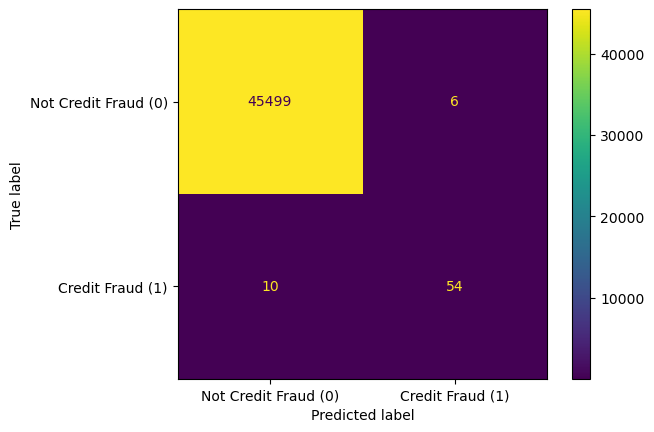



Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45505
           1       0.90      0.84      0.87        64

   micro avg       1.00      1.00      1.00     45569
   macro avg       0.95      0.92      0.94     45569
weighted avg       1.00      1.00      1.00     45569
 samples avg       1.00      1.00      1.00     45569


   Class Accuracies:
    Not Credit Fraud (0)'s accuracy': 1.00
    Credit Fraud (1)'s accuracy': 0.84



In [38]:
confusion_matrix_report(y_pred, y_val)

In [28]:
# make predictions on the test data
y_pred = rf_model_2.predict(X_test)

Confusion matrix:


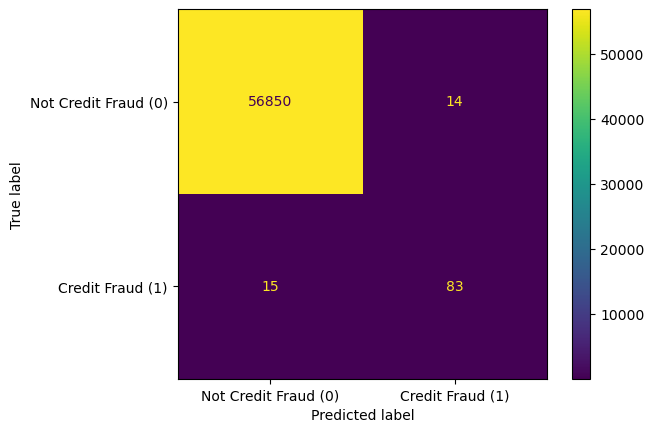



Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.85      0.85        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962
 samples avg       1.00      1.00      1.00     56962


   Class Accuracies:
    Not Credit Fraud (0)'s accuracy': 1.00
    Credit Fraud (1)'s accuracy': 0.85



In [36]:
confusion_matrix_report(y_pred, y_test)